# Naive Bayes Classifier
## Hayden Sather
## CSCI 570
## Spring 2021

## How to Run
1. Ensure that sklearn is downloaded. If not, instructions can be found here: https://scikit-learn.org/stable/install.html
2. Open this ipynb in Jupyter, Colab, or any other python notebook interpreter
3. Hit run at the top, then enjoy!

In [1]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

## Load data

In [2]:
# Train subset
newsgroups_train = fetch_20newsgroups(subset="train")
labels = newsgroups_train.target_names
X_train = newsgroups_train.data
y_train = newsgroups_train.target
num_training_samples = len(y_train)

# Test subset
newsgroups_test = fetch_20newsgroups(subset="test")
X_test = newsgroups_test.data
y_test = newsgroups_test.target
num_testing_samples = len(y_test)

In [48]:
print("Number of training samples", len(y_train))
print("Number of testing samples", len(y_test))
print("Split ratio", len(y_train) / (len(y_train) + len(y_test)))

Number of training samples 11314
Number of testing samples 7532
Split ratio 0.6003395946089356


Define message class to hold information about each class easier

In [3]:
class Message_class():
    def __init__(self):
        self.label = 0
        self.word_dictionary = {}
        self.num_occurs_class = 0
        self.probability_class = 0
        self.n_words_in_class = 0
        self.n_vocab_all = 0

    # Add a new word to dictionary. Increment count if it already exists
    def add_to_dict(self, element):
        if element in self.word_dictionary:
            self.word_dictionary[element] += 1
        else:
            self.word_dictionary[element] = 1
        self.n_words_in_class += 1

Read a list of the 1025 most common words in the english dictionary. This will be used later to ensure that no common words are used in the classificaion scheme

In [4]:
def get_common_words():
    file1 = open('common_files/common_words.txt', 'r')
    Lines = file1.readlines()
    common_words_list = []
    for line in Lines:
        word = line.split()[0]
        common_words_list.append(word.lower())
    return common_words_list

common_words_list = get_common_words()

Read a list of the 1000 most common male and the 1000 most common females names, along with the 30 most common surnames. This will be used later to ensure that no common names are used in the classificaion scheme

In [5]:
def get_common_names():
    file1 = open('common_files/common_names.txt', 'r')
    Lines = file1.readlines()
    common_words_list = []
    for line in Lines:
        word = line.split()[0]
        common_words_list.append(word)
    return common_words_list

common_names_list = get_common_names()

Only add words to each of the classes dictionary if it is not a common word, an email, or a name

In [6]:
def is_name(word, common_names_list):
    return word[0].isupper() and word in common_names_list

In [7]:
def word_valid(word, common_words_list, common_names_list):
    if word[0] == ">":
        word = word[1:]
    if ("@" not in word  # Not an email
        and word.isalpha()  # Is a word
        and word.lower() not in common_words_list  ## Not a common word
        and not is_name(word, common_names_list)):  ## Not a name
        return True
    return False

In [8]:
# Fill message classes dictionaries with words
def fill_dictionaries(message_classes, X_train, y_train, common_words_list, common_names_list):
    for message, label in zip(X_train, y_train):
        message_list = message.split()
        message_classes[label].num_occurs_class += 1
        message_classes[label].label = label
        for word in message_list:
            if word_valid(word, common_words_list, common_names_list):
                message_classes[label].add_to_dict(word)

In [9]:
# Get probability of each class given the word
def fill_probabilities(message_classes, num_training_samples):
    for msg in message_classes:
        msg.probability_class = msg.num_occurs_class / num_training_samples

## Train naive bayes on training data

In [10]:
def train(message_classes, X_train, y_train, common_words_list, common_names_list):
    fill_dictionaries(message_classes, X_train, y_train, common_words_list, common_names_list)
    fill_probabilities(message_classes, num_training_samples)

In [11]:
# Create a list of message classes, one for each of the classes
n_classes = len(np.unique(y_test))
message_classes = [Message_class() for i in range(n_classes)]
# Train on training data
train(message_classes, X_train, y_train, common_words_list, common_names_list)

In [12]:
# Get total number of words in vocabulary
def get_n_words_in_vocab(message_classes):
    # Get n_vocab
    n_vocab = 0
    for msg_class in message_classes:
        n_vocab += msg_class.n_words_in_class
    # Set n_vocab
    for msg_class in message_classes:
        msg_class.n_vocab_all = n_vocab

get_n_words_in_vocab(message_classes)

In [13]:
# Get probability that a word is in a class
def prob_word_given_class(mess_class, word, alpha=1):
    n_vocab = mess_class.n_vocab_all
    n_wi_class = 0
    if word in mess_class.word_dictionary:
        n_wi_class = mess_class.word_dictionary[word]

    return (n_wi_class + alpha) / (mess_class.n_words_in_class + alpha*n_vocab)

In [14]:
# Get the probability that the input words are part of a class
def prob_class_given_words(mess_class, word_list):
    product = 1
    for word in word_list:
        # Use log trick to avoid underflow errors
        product += math.log(prob_word_given_class(mess_class, word))
    return product

## Predictions

In [15]:
def predict(message_classes, message):
    message_list = message.split()
    message_list_cleaned = []
    for word in message_list:
        if word_valid(word, common_words_list, common_names_list):
            message_list_cleaned.append(word)
    
    largest_prod = -999999
    best_class = 0
    for mess_class in message_classes:
        # Calculate the probability that the input is in each class
        product = prob_class_given_words(mess_class, message_list_cleaned)
        if product > largest_prod:
            largest_prod = product
            best_class = mess_class.label
    return best_class

In [16]:
def predict_binary(message_classes, message, class_1, class_2):
    message_list = message.split()
    message_list_cleaned = []
    for word in message_list:
        if word_valid(word, common_words_list, common_names_list):
            message_list_cleaned.append(word)
    
    mess_class_1 = message_classes[class_1]
    mess_class_2 = message_classes[class_2]

    prob_class_1 = prob_class_given_words(mess_class_1, message_list_cleaned)
    prob_class_2 = prob_class_given_words(mess_class_2, message_list_cleaned)

    if prob_class_1 > prob_class_2:
        return class_1
    else:
        return class_2

In [17]:
def predict_binary_2(message_classes, message, class_options):
    message_list = message.split()
    message_list_cleaned = []
    for word in message_list:
        if word_valid(word, common_words_list, common_names_list):
            message_list_cleaned.append(word)
    
    max_probability = -999999
    max_class = 0
    for class_num in class_options:
        probability = prob_class_given_words(message_classes[class_num], message_list_cleaned)
        if probability > max_probability:
            max_class = class_num
            max_probability = probability

    return max_class

## Evaluation

In [39]:
def test_and_evaluate(message_classes, X_test, y_test, verbose=False):
    n_classes = 20
    num_test_samples = len(y_test)
    true_pos_each_class = [0 for i in range(n_classes)]
    true_neg_each_class = [0 for i in range(n_classes)]
    false_pos_each_class = [0 for i in range(n_classes)]
    false_neg_each_class = [0 for i in range(n_classes)]

    # Find 4 classification metrics of each class
    for i in range(num_test_samples):
        prediction = predict(message_classes, X_test[i])
        true_label = y_test[i]
        if prediction == true_label:
            # True positive
            true_pos_each_class[true_label] += 1
            # True negative
            for j in range(n_classes):
                if j != true_label:
                    true_neg_each_class[j] += 1
        else:
            # False positive
            false_pos_each_class[prediction] += 1
            false_neg_each_class[true_label] += 1
            # True negative
            for j in range(n_classes):
                if j != prediction and j != true_label:
                    true_neg_each_class[j] += 1

    # Find evaluation metrics of each class
    total_tp = sum(true_pos_each_class)
    total_tn = sum(true_neg_each_class)
    total_fp = sum(false_pos_each_class)
    total_fn = sum(false_neg_each_class)
    overall_accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
    accuracy_list = []

    if verbose:
        for i in range(n_classes):
            tp = true_pos_each_class[i]
            tn = true_neg_each_class[i]
            fp = false_pos_each_class[i]
            fn = false_neg_each_class[i]
            print(tp, tn, fp, fn)

            print("Metrics for class", labels[i] + ":")
            accuracy = (tp + tn) / (tp + fp + tn + fn)
            accuracy_list.append(accuracy)
            print("  Accuracy:", accuracy)
            precision = tp / (tp + fp)
            print("  Precision:", precision)
            recall = tp / (tp + fn)
            print("  Recall:", recall)
            f1 = 2 / ( (1/recall) + (1/precision))
            print("  F1-score:", f1, "\n")

        # Histogram
        plt.hist(accuracy_list)
        plt.xlabel("Accuracies")
        plt.ylabel("Number of Occurances")
        plt.title("One to Many Classification Accuracies")
        plt.show()

    return overall_accuracy

176 7161 52 143
Metrics for class alt.atheism:
  Accuracy: 0.9741104620286777
  Precision: 0.7719298245614035
  Recall: 0.5517241379310345
  F1-score: 0.6435100548446069 

267 7019 124 122
Metrics for class comp.graphics:
  Accuracy: 0.9673393520977164
  Precision: 0.6828644501278772
  Recall: 0.6863753213367609
  F1-score: 0.6846153846153846 

223 7072 66 171
Metrics for class comp.os.ms-windows.misc:
  Accuracy: 0.968534253850239
  Precision: 0.7716262975778547
  Recall: 0.565989847715736
  F1-score: 0.6530014641288434 

290 6958 182 102
Metrics for class comp.sys.ibm.pc.hardware:
  Accuracy: 0.9622942113648434
  Precision: 0.614406779661017
  Recall: 0.7397959183673469
  F1-score: 0.6712962962962964 

255 7101 46 130
Metrics for class comp.sys.mac.hardware:
  Accuracy: 0.9766330323951142
  Precision: 0.8471760797342193
  Recall: 0.6623376623376623
  F1-score: 0.7434402332361515 

342 6969 168 53
Metrics for class comp.windows.x:
  Accuracy: 0.9706585236325014
  Precision: 0.67058823

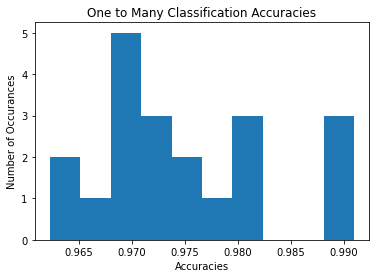

Overall Accuracy: 0.9748406797663304 



In [40]:
overall_accuracy = test_and_evaluate(message_classes, X_test, y_test, range(n_classes))
print("Overall Accuracy:", overall_accuracy, "\n")

In [20]:
def test_and_evaluate_binary(message_classes, X_test, y_test, class_indexes, verbose=False):
    n_classes = len(class_indexes)
    num_test_samples = len(y_test)
    num_correctly_classified = 0
    num_incorrectly_classified = 0

    # Find 4 classification metrics of each class
    for i in range(num_test_samples):
        prediction = predict_binary_2(message_classes, X_test[i], class_indexes)
        true_label = y_test[i]
        if prediction in class_indexes:
            if prediction == true_label:
                num_correctly_classified += 2
                # True positive
            else:
                # False positive
                num_incorrectly_classified += 2
        else:
            num_incorrectly_classified += 2

    # Find evaluation metrics of each class
    overall_accuracy = (num_correctly_classified) / (num_correctly_classified + num_incorrectly_classified)
    return overall_accuracy

In [21]:
def get_new_x_y(X_test, y_test, index):
    X_test_new = []
    y_test_new = []
    for text, label in zip(X_test, y_test):
        if label == index:
            X_test_new.append(text)
            y_test_new.append(label)
    return X_test_new, y_test_new

In [22]:
def get_new_x_y_both(X_test, y_test, indexes):
        X_test_new = []
        y_test_new = []
        for i in indexes:
            X_new, y_new = get_new_x_y(X_test, y_test, i)
            X_test_new += X_new
            y_test_new += y_new

        return X_test_new, y_test_new

In [23]:
def eval_subset(X_test, y_test, indexes):
    X_test_binary, y_test_binary = get_new_x_y_both(X_test, y_test, indexes)
    accuracy = test_and_evaluate_binary(message_classes, X_test_binary, y_test_binary, indexes)
    return accuracy

In [24]:
def eval_binary_pairs():
    num_classes = len(labels)
    pairs_list = []
    accuracy_list = []
    for i in range(num_classes - 1):
        for j in range(i + 1, num_classes):
            accuracy = eval_subset(X_test, y_test, [i, j])
            print(i, j, accuracy)
            accuracy_list.append(accuracy)
            pairs_list.append((i,j))
    return pairs_list, accuracy_list

In [25]:
pairs_list_bi, accuracy_list_bi = eval_binary_pairs()

0 1 0.9703389830508474
0 2 0.9775596072931276
0 3 0.9901547116736991
0 4 0.96875
0 5 0.9845938375350141
0 6 0.9858956276445698
0 7 0.986013986013986
0 8 0.9874476987447699
0 9 0.9846368715083799
0 10 0.9805013927576601
0 11 0.9608391608391609
0 12 0.976123595505618
0 13 0.951048951048951
0 14 0.9663394109396914
0 15 0.8675034867503487
0 16 0.9458272327964861
0 17 0.9064748201438849
0 18 0.9300476947535771
0 19 0.8
1 2 0.8850574712643678
1 3 0.9295774647887324
1 4 0.9328165374677002
1 5 0.8596938775510204
1 6 0.9409499358151476
1 7 0.9707006369426752
1 8 0.9872935196950444
1 9 0.9783715012722646
1 10 0.9847715736040609
1 11 0.932484076433121
1 12 0.8989769820971867
1 13 0.9477707006369427
1 14 0.9578544061302682
1 15 0.96569250317662
1 16 0.9734395750332006
1 17 0.9712418300653595
1 18 0.9656652360515021
1 19 0.9671875
2 3 0.8562340966921119
2 4 0.9293966623876765
2 5 0.8681875792141952
2 6 0.9617346938775511
2 7 0.9810126582278481
2 8 0.98989898989899
2 9 0.9873577749683944
2 10 0.9899

In [26]:
def sort_two_lists(list1, list2):
    zipped_lists = zip(list1, list2)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    return list1, list2

In [37]:
def indices_to_labels(pair, labels):
    if len(pair) == 2:
        return labels[pair[0]], labels[pair[1]]
    elif len(pair) == 3:
        return labels[pair[0]], labels[pair[1]], labels[pair[2]]

In [28]:
def evaluate_accuracies(accuracy_list, pairs_list, bi_tri="Binary"):
    # Histogram
    plt.hist(accuracy_list)
    plt.xlabel("Accuracies")
    plt.ylabel("Number of Occurances")
    plt.title("Pairwise " + bi_tri + " Classification Accuracies")
    plt.show()
    # Worst
    accuracy_list, pairs_list = sort_two_lists(accuracy_list, pairs_list)
    print("Top 5 worst pairs for accuracies")
    for i in range(5):
        print(indices_to_labels(pairs_list[i], labels))
    # Best
    print("Top 5 best pairs for accuracies")
    for i in range(1, 6):
        print(indices_to_labels(pairs_list[-i], labels))

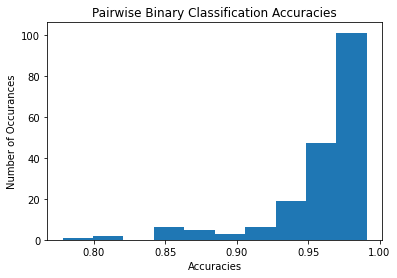

Top 5 worst pairs for accuracies
('soc.religion.christian', 'talk.religion.misc')
('talk.politics.guns', 'talk.politics.misc')
('alt.atheism', 'talk.religion.misc')
('talk.politics.misc', 'talk.religion.misc')
('talk.politics.mideast', 'talk.politics.misc')
Top 5 best pairs for accuracies
('comp.sys.ibm.pc.hardware', 'rec.sport.hockey')
('alt.atheism', 'comp.sys.ibm.pc.hardware')
('rec.sport.hockey', 'sci.space')
('comp.os.ms-windows.misc', 'rec.sport.hockey')
('comp.os.ms-windows.misc', 'rec.motorcycles')


In [29]:
evaluate_accuracies(accuracy_list_bi, pairs_list_bi)

In [35]:
def eval_trinary_pairs():
    num_classes = len(labels)
    pairs_list = []
    accuracy_list = []
    for i in range(num_classes - 2):
        for j in range(i + 1, num_classes - 1):
            for k in range(j + 1, num_classes):
                accuracy = eval_subset(X_test, y_test, [i, j, k])
                print(i, j, k, accuracy)
                accuracy_list.append(accuracy)
                pairs_list.append((i,j,k))
    return pairs_list, accuracy_list

pairs_list_tri, accuracy_list_tri = eval_trinary_pairs()

 13 0.954468802698145
2 7 14 0.9434121621621622
2 7 15 0.9629629629629629
2 7 16 0.951473136915078
2 7 17 0.9605488850771869
2 7 18 0.9454545454545454
2 7 19 0.9644572526416907
2 8 9 0.9806560134566863
2 8 10 0.9865659109991604
2 8 11 0.9377104377104377
2 8 12 0.9383966244725739
2 8 13 0.9612794612794613
2 8 14 0.9637436762225969
2 8 15 0.9663865546218487
2 8 16 0.96280276816609
2 8 17 0.9571917808219178
2 8 18 0.9528130671506352
2 8 19 0.9741131351869607
2 9 10 0.9605042016806723
2 9 11 0.941027801179444
2 9 12 0.9434121621621622
2 9 13 0.953664700926706
2 9 14 0.959493670886076
2 9 15 0.960470984020185
2 9 16 0.9679653679653679
2 9 17 0.961439588688946
2 9 18 0.9509536784741145
2 9 19 0.9731285988483686
2 10 11 0.9461732548359967
2 10 12 0.9443507588532883
2 10 13 0.9655172413793104
2 10 14 0.9679865206402696
2 10 15 0.9689336691855583
2 10 16 0.975799481417459
2 10 17 0.9700598802395209
2 10 18 0.9637352674524026
2 10 19 0.9693486590038314
2 11 12 0.8605240912933221
2 11 13 0.933389

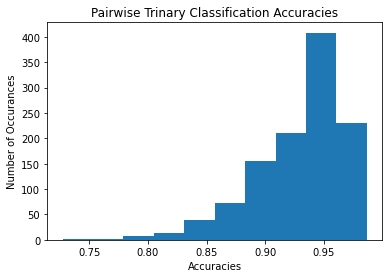

Top 5 worst pairs for accuracies
('alt.atheism', 'soc.religion.christian', 'talk.religion.misc')
('talk.politics.guns', 'talk.politics.misc', 'talk.religion.misc')
('alt.atheism', 'talk.politics.misc', 'talk.religion.misc')
('talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc')
('alt.atheism', 'talk.politics.mideast', 'talk.religion.misc')
Top 5 best pairs for accuracies
('comp.os.ms-windows.misc', 'rec.motorcycles', 'rec.sport.hockey')
('comp.sys.ibm.pc.hardware', 'rec.motorcycles', 'rec.sport.hockey')
('comp.windows.x', 'rec.motorcycles', 'rec.sport.hockey')
('rec.motorcycles', 'rec.sport.hockey', 'sci.space')
('comp.sys.mac.hardware', 'rec.motorcycles', 'rec.sport.hockey')


In [38]:
evaluate_accuracies(accuracy_list_tri, pairs_list_tri, bi_tri="Trinary")